#Mount Google Drive and Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15730, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 15730 (delta 206), reused 301 (delta 112), pack-reused 15277
Receiving objects: 100% (15730/15730), 6.51 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (11322/11322), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.

#Setuo Dectron2 and Import Libraries

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


#Convert JSON files and Merge Data

In [ ]:
def convert_json_files(json_dir, image_dir, images, annotations, start_image_id, start_annotation_id):
    current_image_id = start_image_id
    current_annotation_id = start_annotation_id

    for json_file in os.listdir(json_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_dir, json_file)
            with open(json_path) as f:
                data = json.load(f)

            for entry in data["FILE"]:
                file_name = entry["FILE_NAME"]
                file_path = os.path.join(image_dir, file_name)
                if not os.path.exists(file_path):
                    continue

                # Read image size
                height, width = cv2.imread(file_path).shape[:2]

                # Append image info
                images.append({
                    "file_name": file_path,
                    "height": height,
                    "width": width,
                    "id": current_image_id
                })

                for item in entry["ITEMS"]:
                    if item["DRAWING"] == "Box":
                        bbox = list(map(float, item["BOX"].split(',')))
                        xmin, ymin, width, height = bbox[0], bbox[1], bbox[2], bbox[3]

                        # Determine class based on "CLASS" field
                        class_name = item["CLASS"]
                        if class_name == "적재불량":
                            category_id = 1
                        elif class_name == "정상차량":
                            category_id = 0
                        else:
                            continue  # Ignore entries that are not classified as "적재불량" or "정상차량"

                        # Append annotation info
                        annotations.append({
                            "bbox": [xmin, ymin, width, height],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "category_id": category_id,
                            "image_id": current_image_id,
                            "id": current_annotation_id,
                            "segmentation": [],
                            "area": width * height,
                            "iscrowd": 0
                        })
                        current_annotation_id += 1

                current_image_id += 1

    return current_image_id, current_annotation_id

def merge_json_files(training=True):
    base_dir = "/content/drive/MyDrive/Data/training" if training else "/content/drive/MyDrive/Data/validation" # 데이터 경로 지정 필요

    merged_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 0, "name": "normal_vehicle"},  # 정상 차량
            {"id": 1, "name": "overloaded_vehicle"}  # 적재불량 차량
        ]
    }

    current_image_id = 0
    current_annotation_id = 0

    json_dir = os.path.join(base_dir, "labeled")
    image_dir = os.path.join(base_dir, "source")

    current_image_id, current_annotation_id = convert_json_files(
        json_dir, image_dir,
        merged_data["images"], merged_data["annotations"],
        current_image_id, current_annotation_id
    )

    output_file = "merged_training_annotations.json" if training else "merged_validation_annotations.json"
    with open(output_file, 'w') as f:
        json.dump(merged_data, f, indent=4)

# Training 데이터셋 병합 및 변환
merge_json_files(training=True)

# Validation 데이터셋 병합 및 변환
merge_json_files(training=False)


#Register Datates and Visualize

Train Dataset Metadata: Metadata(name='vehicle_train', json_file='merged_training_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
Validation Dataset Metadata: Metadata(name='vehicle_val', json_file='merged_validation_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
WARNING [06/17 07:31:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/17 07:31:26 d2.data.datasets.coco]: Loaded 280 images in COCO format from merged_training_annotations.json


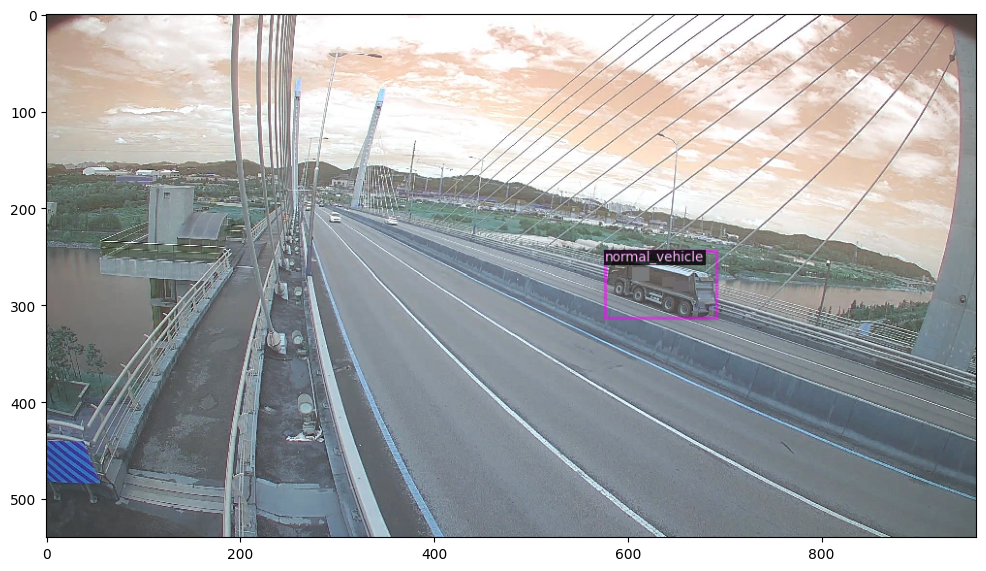

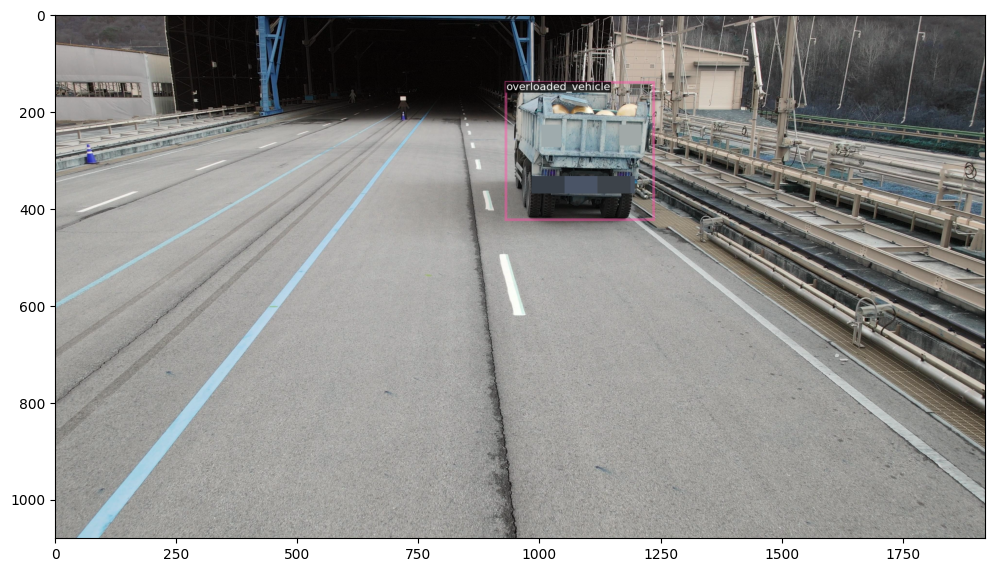

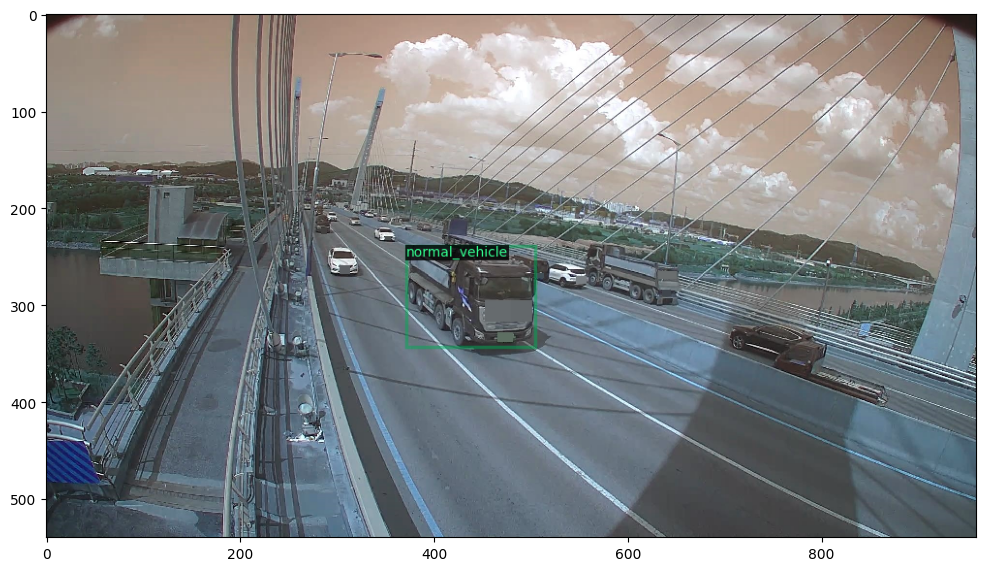

In [ ]:
# 파일 경로 설정
training_json = "merged_training_annotations.json"
validation_json = "merged_validation_annotations.json"
image_dir = "/content/drive/MyDrive/Data"  # 경로 지정 필요

# 데이터셋 등록
register_coco_instances("vehicle_train", {}, training_json, image_dir)
register_coco_instances("vehicle_val", {}, validation_json, image_dir)

# 메타데이터 가져오기
train_metadata = MetadataCatalog.get("vehicle_train")
val_metadata = MetadataCatalog.get("vehicle_val")

print("Train Dataset Metadata:", train_metadata)
print("Validation Dataset Metadata:", val_metadata)

# training 데이터셋 시각화
train_dataset_dicts = DatasetCatalog.get("vehicle_train")
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


#Train the model

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)
cfg.DATASETS.TEST = ("vehicle_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 모델 사용
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # 학습 반복 횟수 조정
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 두 가지 클래스: 정상차량과 적재불량 차량

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[06/17 07:31:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 176MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/17 07:31:44 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/17 07:32:02 d2.utils.events]:  eta: 0:08:20  iter: 19  total_loss: 1.509  loss_cls: 1.041  loss_box_reg: 0.4122  loss_rpn_cls: 0.02019  loss_rpn_loc: 0.001874    time: 0.5487  last_time: 0.8914  data_time: 0.0936  last_data_time: 0.4172   lr: 4.9953e-06  max_mem: 2548M
[06/17 07:32:18 d2.utils.events]:  eta: 0:08:32  iter: 39  total_loss: 1.328  loss_cls: 0.9555  loss_box_reg: 0.3353  loss_rpn_cls: 0.02319  loss_rpn_loc: 0.001994    time: 0.5713  last_time: 0.4976  data_time: 0.1186  last_data_time: 0.0166   lr: 9.9902e-06  max_mem: 2549M
[06/17 07:32:29 d2.utils.events]:  eta: 0:08:13  iter: 59  total_loss: 1.297  loss_cls: 0.8111  loss_box_reg: 0.459  loss_rpn_cls: 0.01434  loss_rpn_loc: 0.001848    time: 0.5697  last_time: 0.7368  data_time: 0.1096  last_data_time: 0.2483   lr: 1.4985e-05  max_mem: 2550M
[06/17 07:32:42 d2.utils.events]:  eta: 0:08:33  iter: 79  total_loss: 1.046  loss_cls: 0.6227  loss_box_reg: 0.3813  loss_rpn_cls: 0.01637  loss_rpn_loc: 0.001291    time: 0.58

#Evaluate Model Performance

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # "적재불량 차량"과 "정상 차량" 두 가지 클래스
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 학습된 모델 가중치
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 테스트 시 사용할 confidence threshold

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론 수행
def perform_inference(image_path, predictor, metadata):
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}.")
        return

    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요
perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 평가를 위한 데이터 로더 및 평가자 초기화
evaluator = COCOEvaluator("vehicle_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "vehicle_val")

# 모델 성능 평가.
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)


# easy ocr


#result image saving

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론을 수행하고 결과를 저장하는 함수
def perform_inference(image_path, predictor, metadata):
    result_overload = []
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return result_overload

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}.")
        return result_overload

    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_overload.append(out.get_image()[:, :, ::-1])

    return result_overload

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요

# 결과 저장
result_overload = perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 결과 시각화
for result in result_overload:
    plt.figure(figsize=(14, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.show()


#import easy ocr

In [ ]:
#you need to install pytorch in anaconda environment
import os
import locale
import subprocess

# Check if locale is set correctly locale.setlocale(locale.LC_ALL, 'UTF-8')

# Install EasyOCR
!pip install easyocr

import torch.backends.cudnn as cudnn
import yaml
import pandas as pd
import easyocr

# Uncomment if these are defined elsewhere
# from train import train
# from utils import AttrDict

cudnn.benchmark = True
cudnn.deterministic = False

reader = easyocr.Reader(['ko']) # this needs to run only once to load the model into memory

#파일 불러오기

In [ ]:
import os
import cv2 as cv

# Iterate over the files in the directory
for i in os.listdir(result_overload):
    path = result_overload + i

    # Read the image
    img_color = cv.imread(path, cv.IMREAD_COLOR)

    # Display the image
    cv.imshow("image", img_color)
    cv.waitKey(0)

# Read the Chinese image
img = cv2.imread(result_overload)

# Perform OCR on the image
result = reader.readtext(img, detail=0)